In [53]:
import torch 
import torch.nn.functional as F
import torch.nn as nn

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [54]:
data = pd.read_csv("winequality-red.csv",sep=";")

# z-normalize all columns
colsZscore = data.keys()
data[colsZscore] = data[colsZscore].apply(stats.zscore)

In [55]:
# removing outliers
data = data[data["total sulfur dioxide"] < 200]

In [56]:
colsZscore = colsZscore.drop("residual sugar")

dataT = torch.tensor(data[colsZscore].values).float()
labels = torch.tensor(data['residual sugar'].values).float()
labels = labels[:,None] # transform to matrix

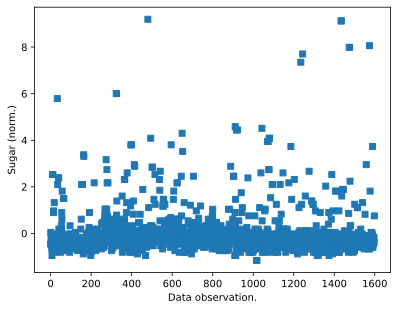

In [57]:
plt.plot(labels,'s')
plt.xlabel("Data observation.")
plt.ylabel("Sugar (norm.)")
plt.show()

In [58]:
train_dataSK,test_dataSK,train_labelsSK,test_labelsSK=train_test_split(dataT,labels,test_size=.2)

train_dataSet = TensorDataset(train_dataSK,train_labelsSK)
test_dataset = TensorDataset(test_dataSK,test_labelsSK)

test_loader = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataSet,batch_size=32,shuffle=True,drop_last=True)

In [59]:
class NetWithBNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input = nn.Linear(11,16)
        
        self.fc1 = nn.Linear(16,32)
        # self.bnorm1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(32,32)
        # self.bnorm2 = nn.BatchNorm1d(32)
        
        
        self.output = nn.Linear(32,1)
        
    def forward(self,x,doBN):
        
        x = F.leaky_relu(self.input(x))
        
        if doBN:
            
            # x = self.bnorm1(x)
            x = F.leaky_relu(self.fc1(x))
            
            # x = self.bnorm2(x)
            x = F.leaky_relu(self.fc2(x))
            
        else:
            
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
        
        return self.output(x)

In [60]:
num_epoch = 1000

def trainModel(doBN=True):
    
    lossFn = nn.MSELoss()
    optimizer = torch.optim.SGD(wineNet.parameters(), lr=0.01)
    
    # init losses
    trainLoss = torch.zeros(num_epoch)
    testLoss = torch.zeros(num_epoch)
    
    for epochI in range(num_epoch):
        
        wineNet.train()
        
        batchLoss =[]
        for X,y in train_loader:
            
            yHat = wineNet(X,doBN=doBN)
            loss = lossFn(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
        trainLoss[epochI] = np.mean(batchLoss)
        
        ### test acc
        wineNet.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = wineNet(X,doBN=doBN)
        testLoss[epochI] = lossFn(yHat,y).item()
        
    return trainLoss,testLoss

### for measuring acc in regression we can use correlation between yHat and y

In [61]:
wineNet = NetWithBNorm()

trainLoss,testLoss = trainModel()

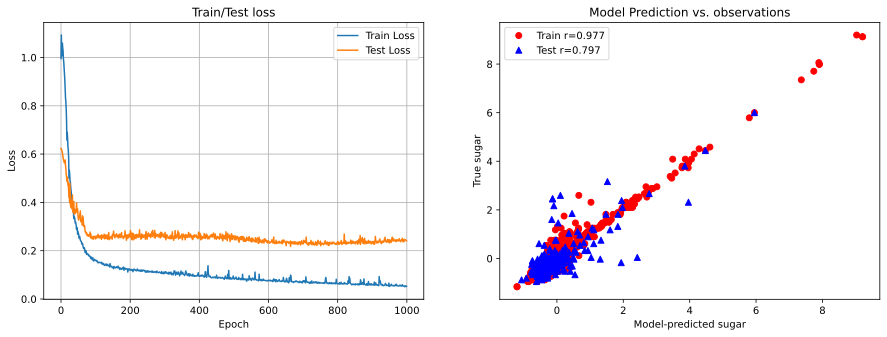

In [63]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(trainLoss,label="Train Loss")
ax[0].plot(testLoss,label="Test Loss")
ax[0].set_title("Train/Test loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].legend()

# show predictions and real values
yHatTrain = wineNet(train_dataSK,doBN=False)
yHatTest = wineNet(test_dataSK,doBN=False)
ax[1].plot(yHatTrain.detach(),train_labelsSK,'ro')
ax[1].plot(yHatTest.detach(),test_labelsSK,'b^')
ax[1].set_xlabel("Model-predicted sugar")
ax[1].set_ylabel("True sugar")
ax[1].set_title("Model Prediction vs. observations")

# correlations between predictions and observations
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelsSK.T)[1,0]
corrTest = np.corrcoef(yHatTest.detach().T,test_labelsSK.T)[1,0]
ax[1].legend([f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}'])

plt.show()

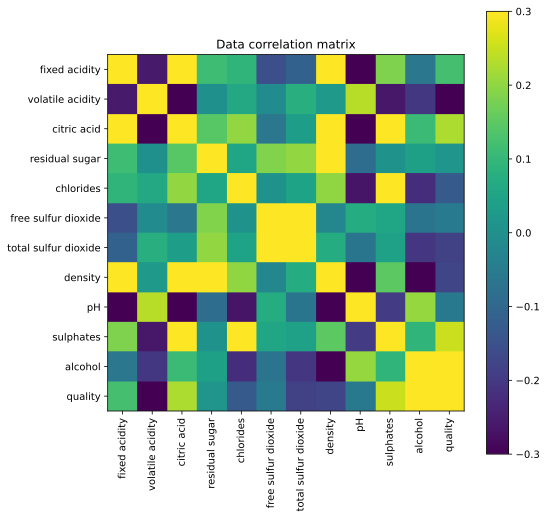

In [64]:
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title("Data correlation matrix")
plt.show()